In [342]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [441]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as ticker

sns.set(style="whitegrid")

from api.questrade import QTClient

In [344]:
REFRESH_TOKEN = "edV19WQzVACHuC3sfzeX6Qv0UIOwNpoA0"

In [345]:
client = QTClient(REFRESH_TOKEN)

# Show Open PnL

In [346]:
positions = pd.DataFrame(client.get_account_positions())
positions

,averageEntryPrice,closedPnl,closedQuantity,currentMarketValue,currentPrice,dayPnl,isRealTime,isUnderReorg,openPnl,openQuantity,symbol,symbolId,totalCost
0,40.800000,0,0,187.85,37.57,-4.80,False,False,-16.150000,5,ROBO,4807280,204.000000
1,23.510000,0,0,234.20,23.42,-6.00,False,False,-0.900000,10,TAN,21806477,235.100000
2,23.398317,0,0,228.60,19.05,-5.64,False,False,-52.179804,12,BOTZ,15029143,280.779804


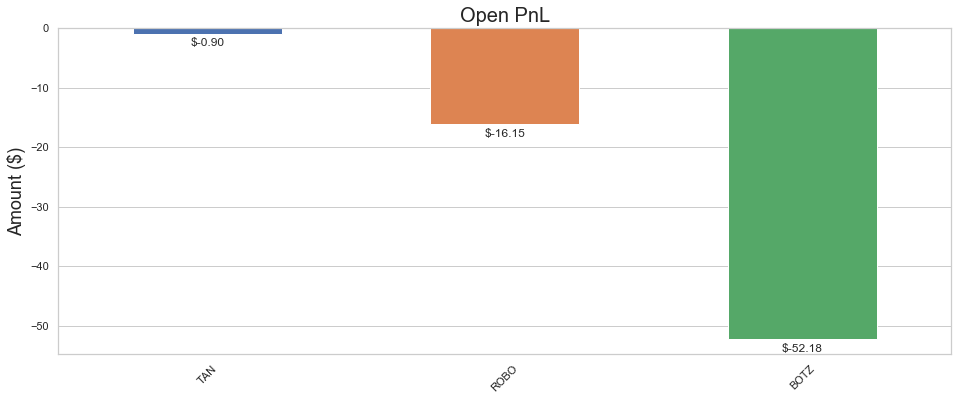

In [347]:
%matplotlib inline
positions.sort_values(by=['openPnl'], inplace=True, ascending=False)
ax = positions.plot(x='symbol', y='openPnl', kind='bar', figsize=(16, 6), legend=False)
ax.set_title('Open PnL', fontsize=20)
ax.set_ylabel('Amount ($)', fontsize=18)
ax.set_xlabel('')
ax.grid(axis='x')
rects = ax.patches
for rect, label in zip(rects, positions['openPnl']):
    height = rect.get_height()
    if height < 0:
        height -= 2.5
    ax.text(rect.get_x() + rect.get_width() / 2, height, '$%.2f' % label,
            ha='center', va='bottom', fontsize=12)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

In [348]:
print("Open PnL: %f" % (positions['openPnl'].sum()))

Open PnL: -69.229804


# Stitch market data for all securities into one DataFrame

## Add other securities to the list

In [461]:
watch_securities = pd.read_csv('/Users/kzabashta/Downloads/seclist.csv', 
                               names=["ticker", "description"]).set_index("ticker")

In [493]:
symbols = dict(zip(positions["symbolId"], positions["symbol"]))

watch_securities = pd.read_csv('/Users/kzabashta/Downloads/seclist.csv', 
                               names=["ticker", "description"]).set_index("ticker").head(200)
additional_securities = list(watch_securities.index)
additional_securities = ['FXM']

for symbol in additional_securities:
    matched_securities = client.search(symbol)
    if len(matched_securities) > 1:
        if not "." in matched_securities[0]['symbol'] and len(matched_securities[0]['symbol'].split()) == 1:
            match_symbol = symbol.split()[0].strip()
            match = list(filter(lambda x: x['symbol'] == "%s.TO" % match_symbol and x["isTradable"] == True, 
                                matched_securities))
            print(match)
            if len(match) == 1:
                print("%s <=> %s" %(symbol, match[0]['symbol']))
            else:
                print("%s <=> %s" % (symbol, matched_securities[0]['symbol']))
            symbols[matched_securities[0]['symbolId']] = matched_securities[0]['symbol']
        else:
            print("%s <=> %s" %(symbol, matched_securities[0]['symbol']))
            symbols[matched_securities[0]['symbolId']] = matched_securities[0]['symbol']

[{'symbol': 'FXM.TO', 'symbolId': 2182948, 'description': 'F A MORNINGSTAR CDA VALUE IDX ETF', 'securityType': 'Stock', 'listingExchange': 'TSX', 'isTradable': True, 'isQuotable': True, 'currency': 'CAD'}]
FXM <=> FXM.TO


In [494]:
FROM_DATE = '2016-10-01T00:00:00-05:00'
TO_DATE = '2019-10-20T23:59:59-05:00'

historicals = pd.DataFrame()
for symbolId, symbol in symbols.items():
    print(symbol)
    candles = pd.DataFrame(client.get_candles(symbolId, FROM_DATE, TO_DATE, 'OneDay')['candles'])
    candles['end'] =  pd.to_datetime(candles['end'], format='%Y-%m-%d')
    candles['symbol'] = symbol
    candles['symbolId'] = symbol_id
    historicals = historicals.append(candles)
historicals = historicals.set_index(["symbol", "end"])

TAN
ROBO
BOTZ
FXM


KeyError: 'candles'

# Plot historical data

['BOTZ', 'CDZ.TO', 'CHB.TO', 'CIE.TO', 'CJP.TO', 'CLU.C.TO', 'CRQ.TO', 'CUD.TO', 'CWO.TO', 'CYH.TO', 'EHE.B.TO', 'ETHI.TO', 'FTN.PRA.TO', 'FXM.TO', 'HCN.TO', 'HEX.TO', 'HIU.TO', 'HIX.TO', 'HSH.TO', 'HXQ.TO', 'HXS.TO', 'HXT.TO', 'PDC.TO', 'PDF.TO', 'ROBO', 'TAN', 'TXF.TO', 'VCE.TO', 'VCN.TO', 'VDU.TO', 'VEE.TO', 'VEF.TO', 'VFV.TO', 'VLQ.TO', 'VMO.TO', 'VSP.TO', 'VUN.TO', 'VUS.TO', 'VVL.TO', 'VXC.TO', 'VXM.B.TO', 'WXM.TO', 'XCS.TO', 'XDG.TO', 'XDU.TO', 'XDV.TO', 'XEC.TO', 'XEH.TO', 'XEM.TO', 'XIN.TO', 'XIU.TO', 'XMC.TO', 'XMD.TO', 'XSP.TO', 'XSU.TO', 'XTR.TO', 'XUS.TO', 'XXM.B.TO', 'YXM.B.TO', 'ZBK.TO', 'ZCN.TO', 'ZDM.TO', 'ZDV.TO', 'ZDY.TO', 'ZEM.TO', 'ZSP.TO', 'ZXM.B.TO']


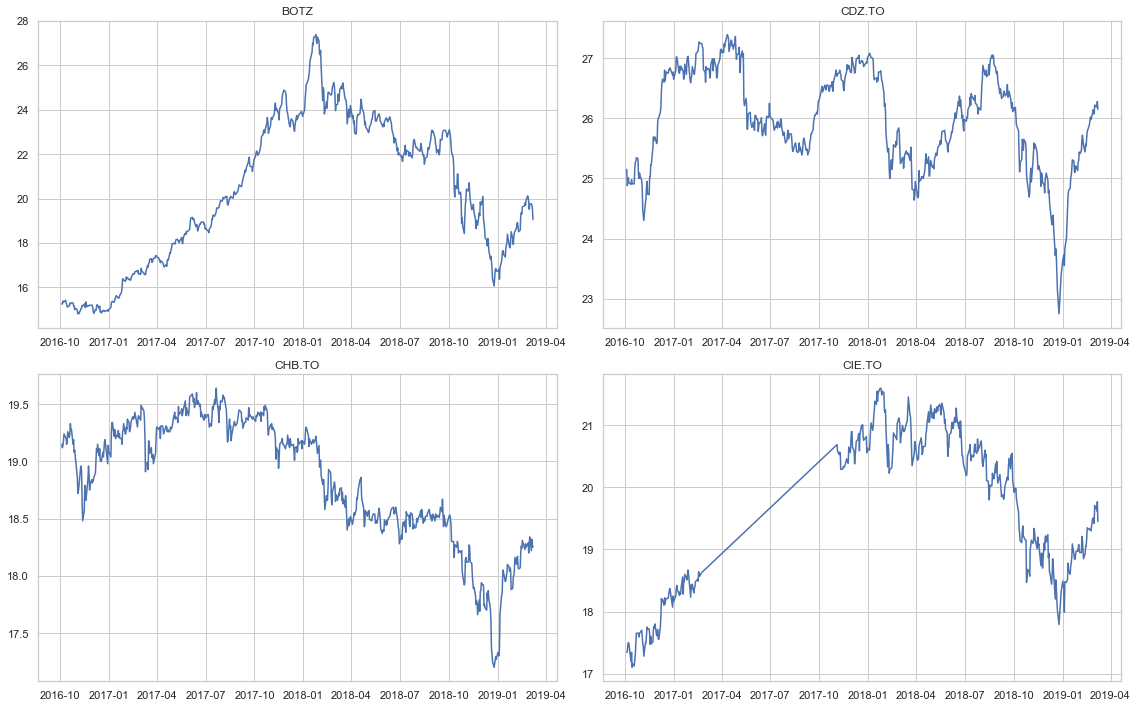

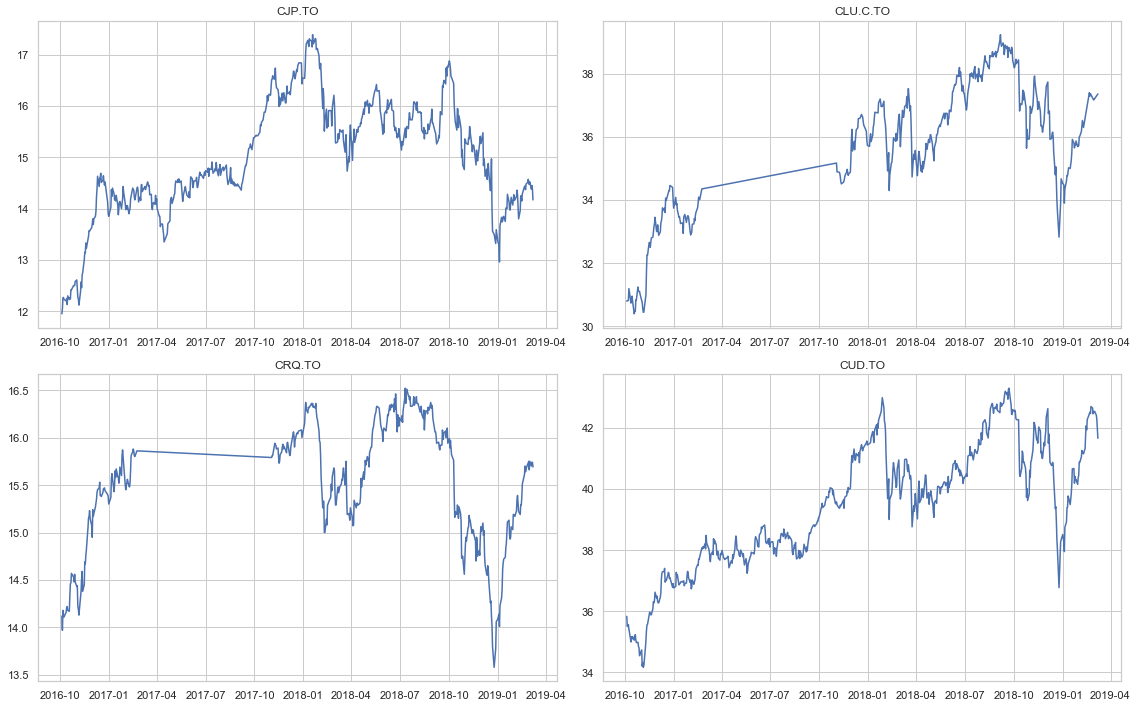

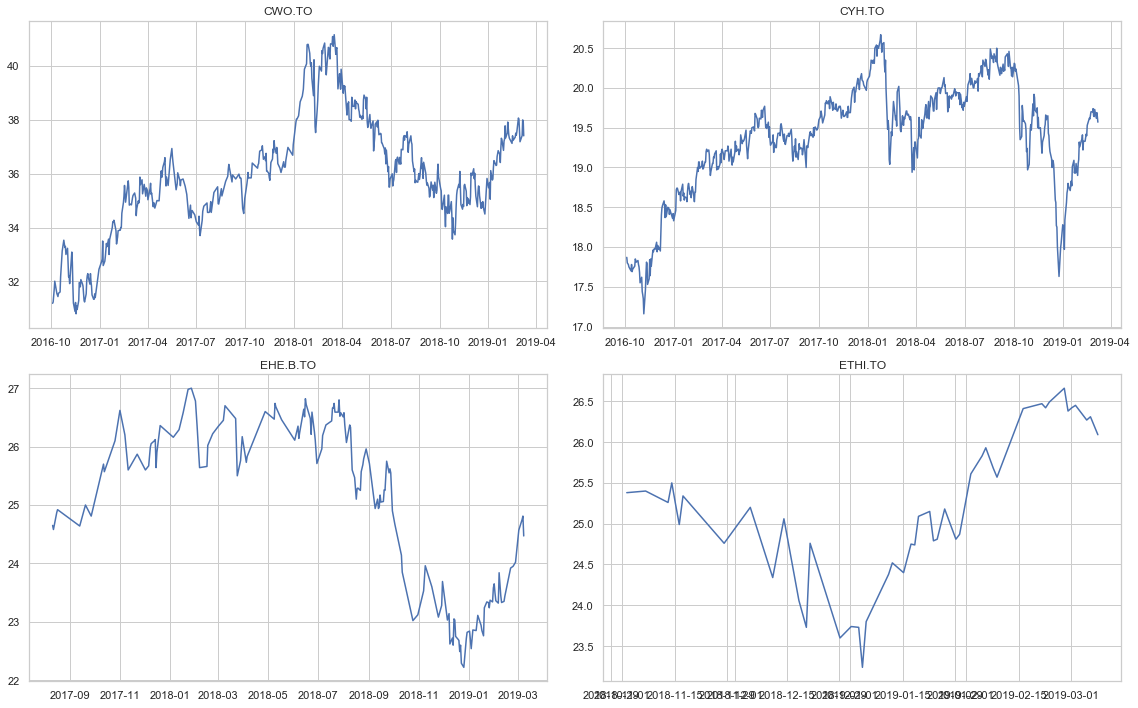

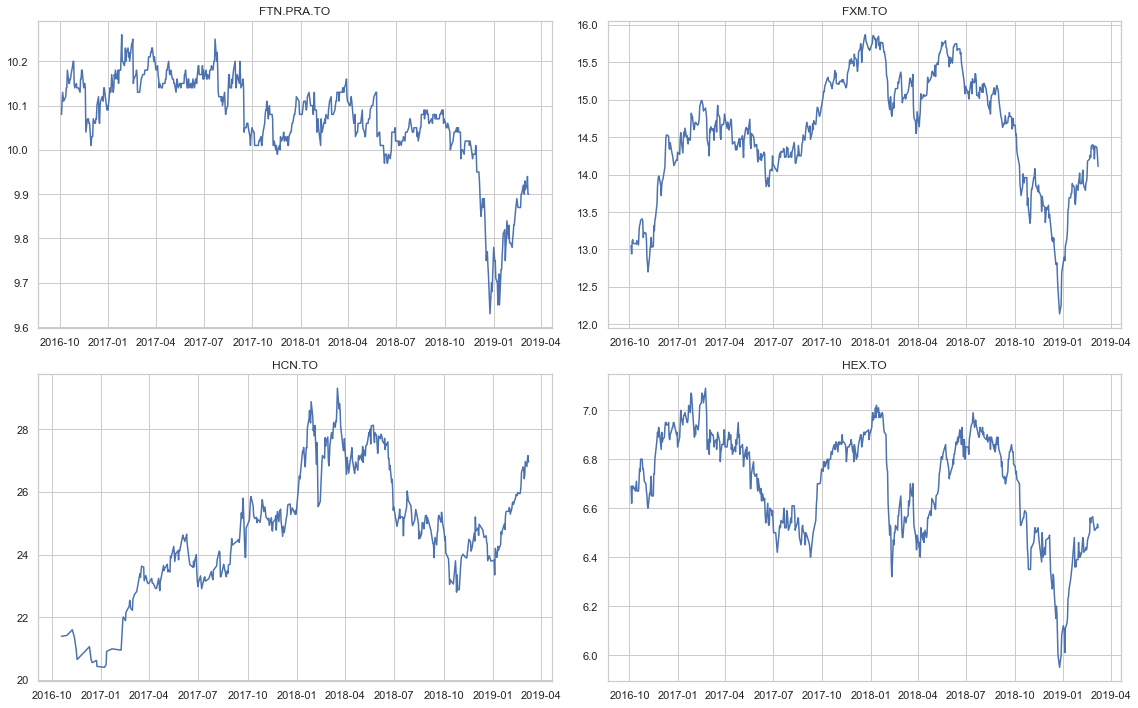

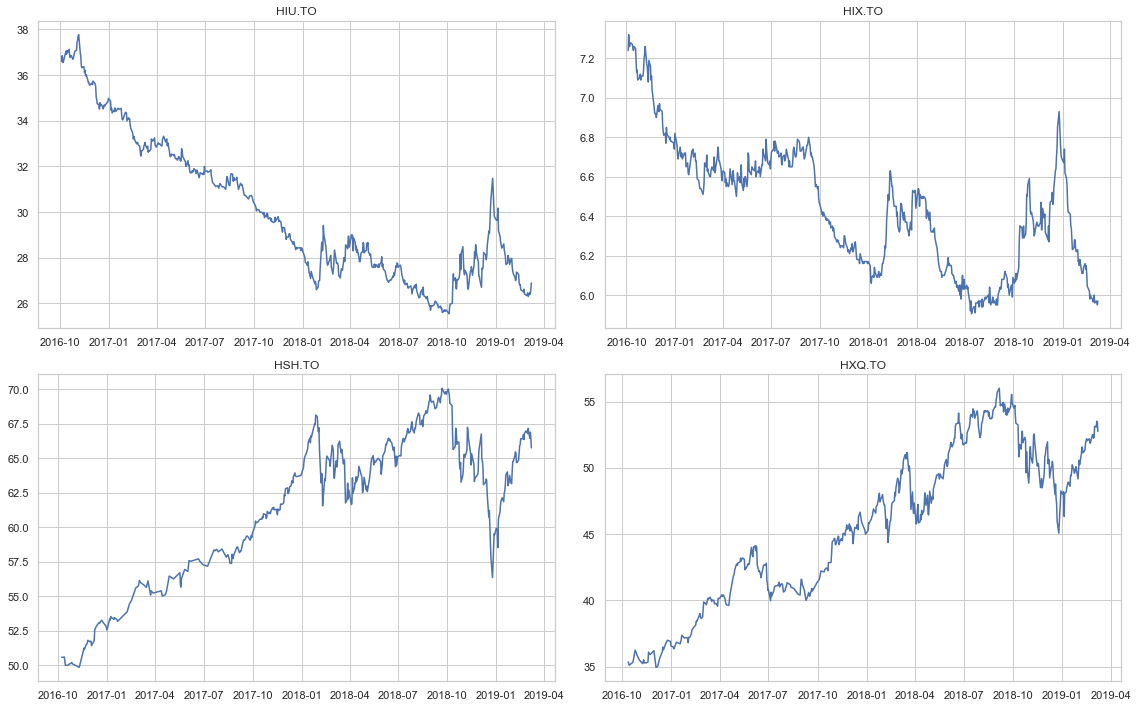

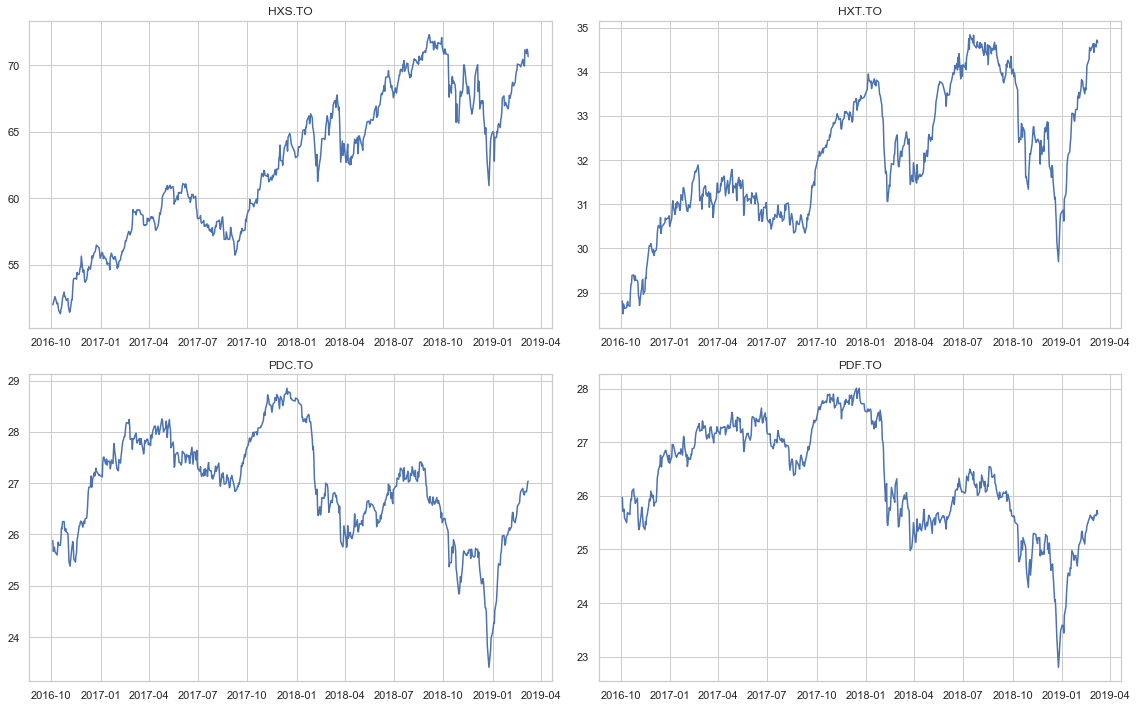

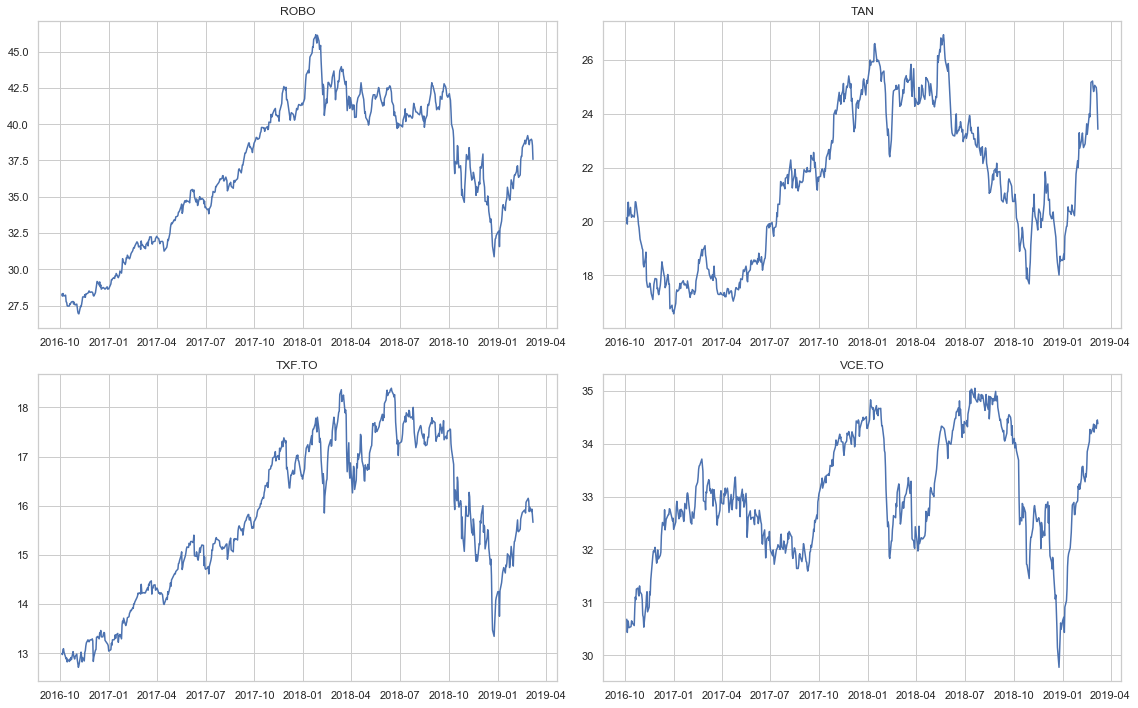

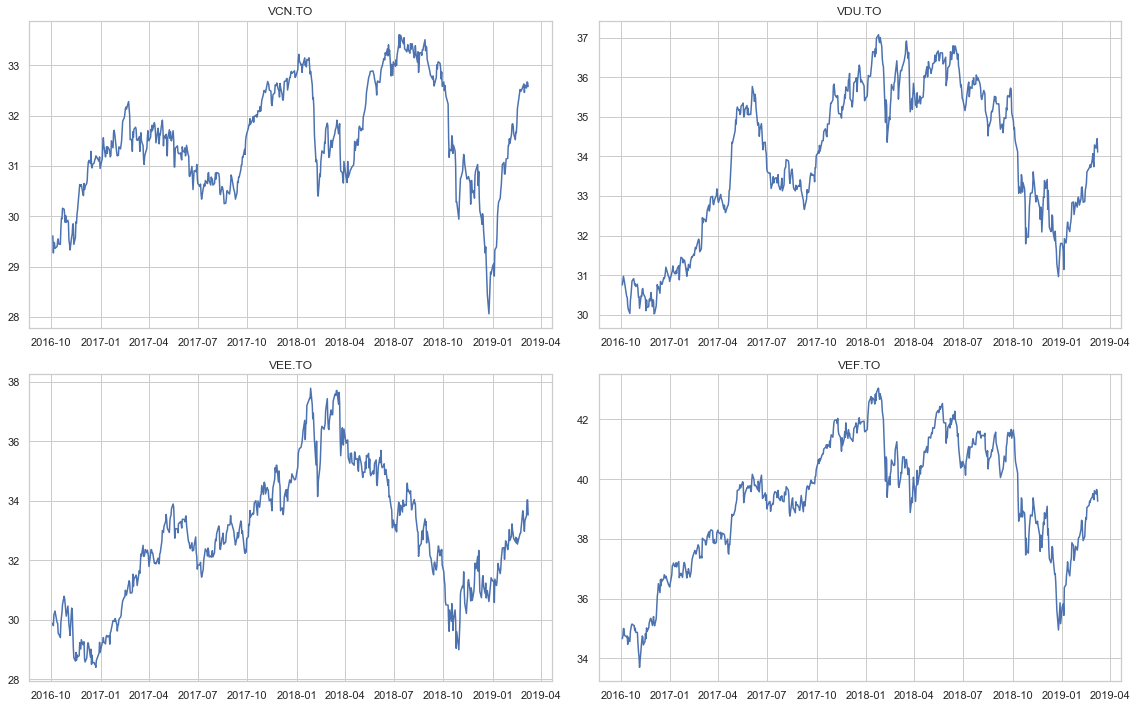

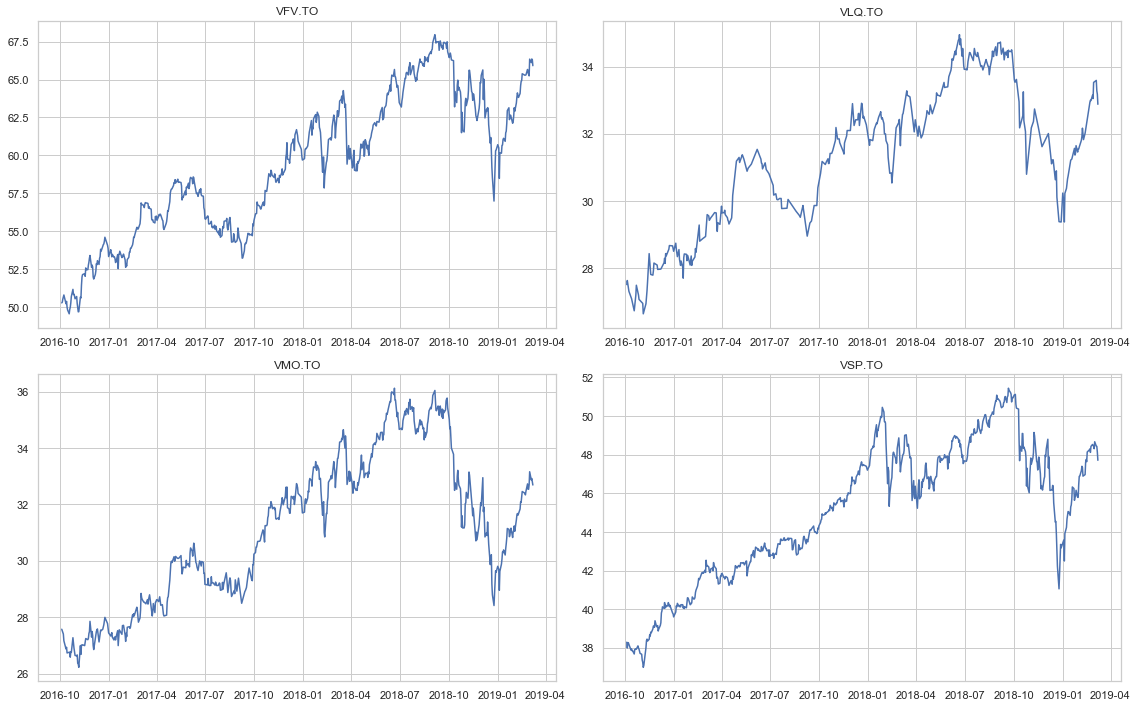

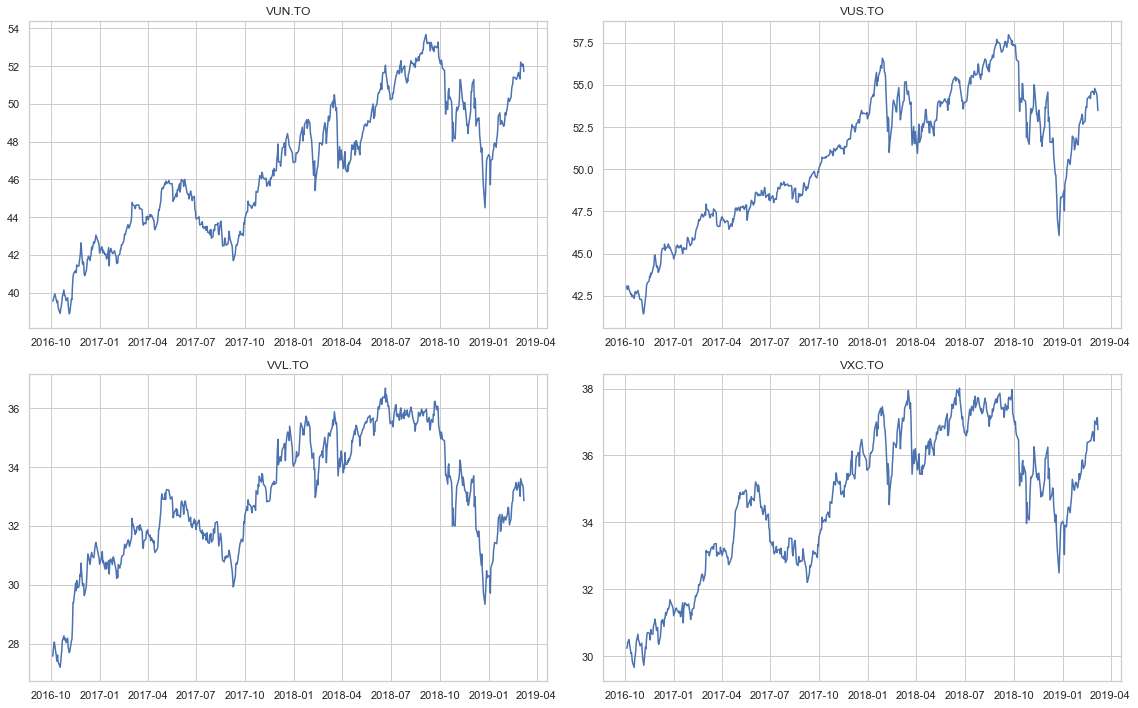

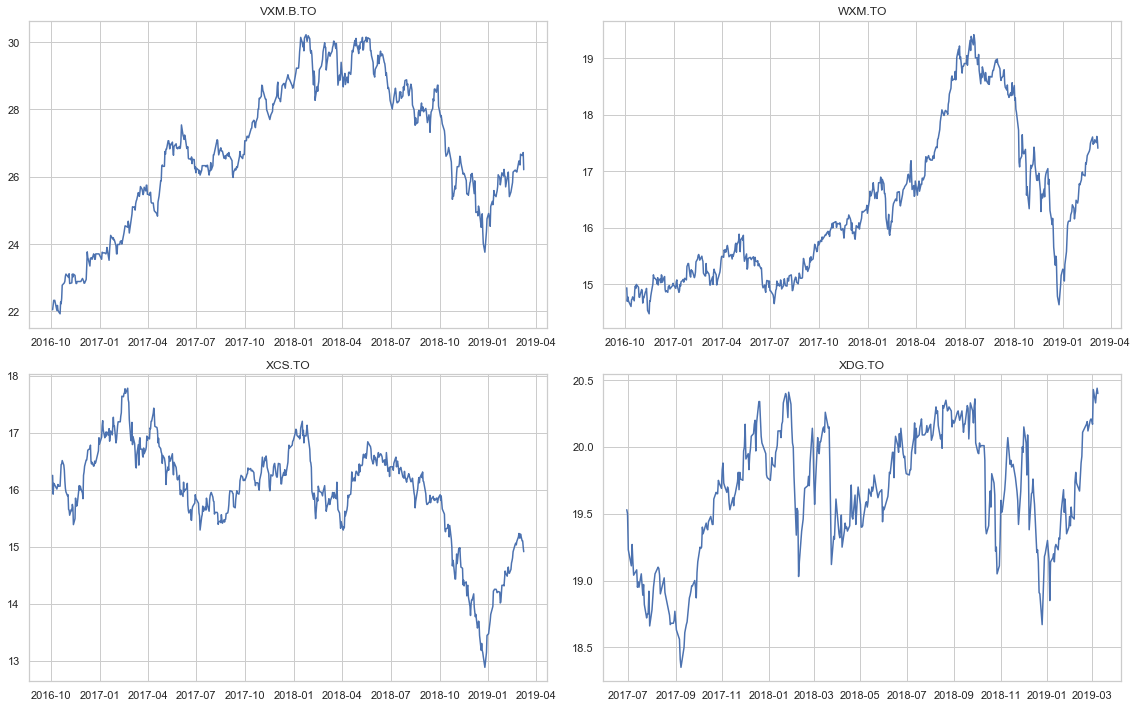

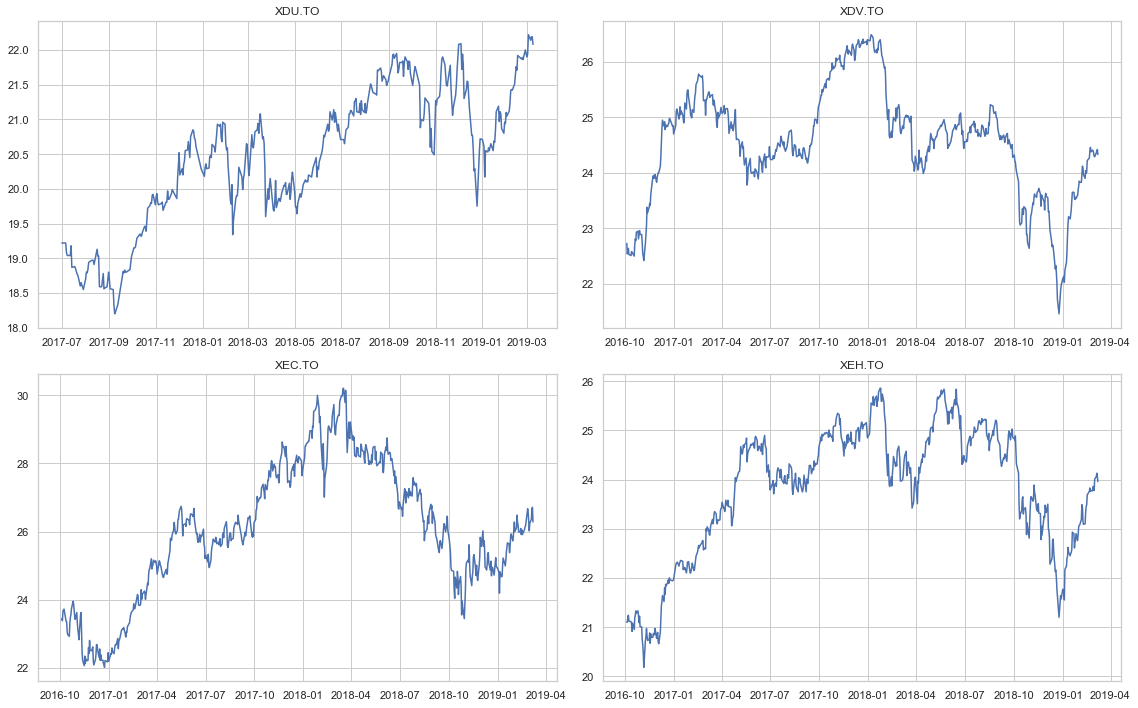

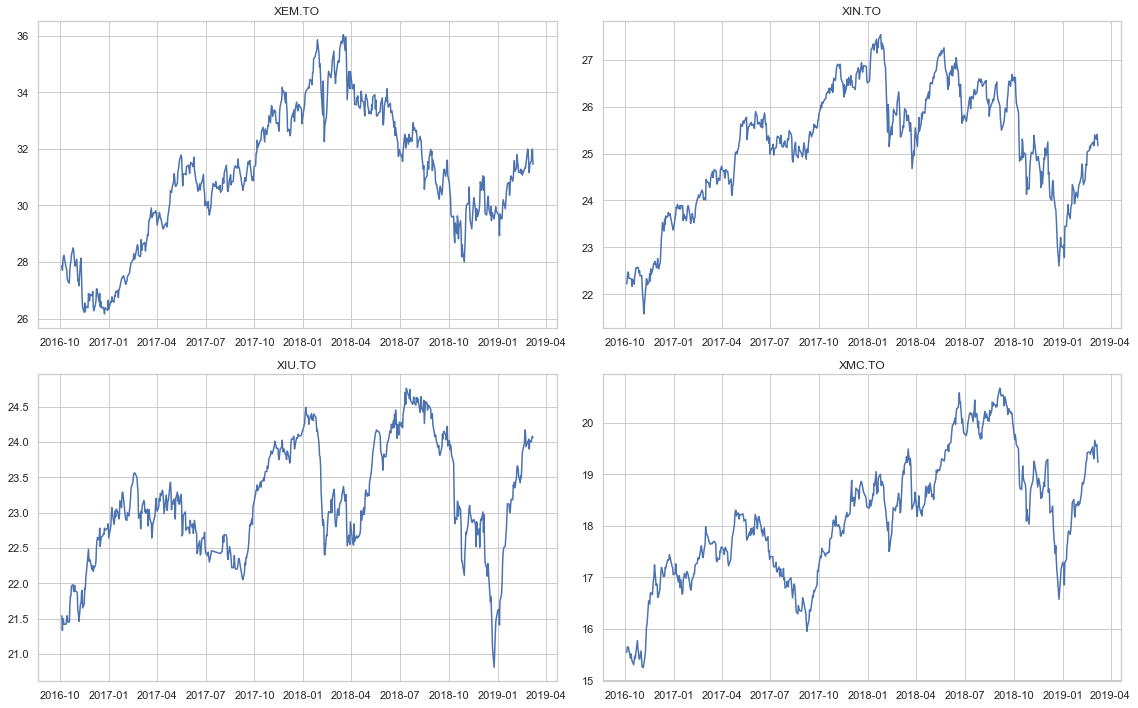

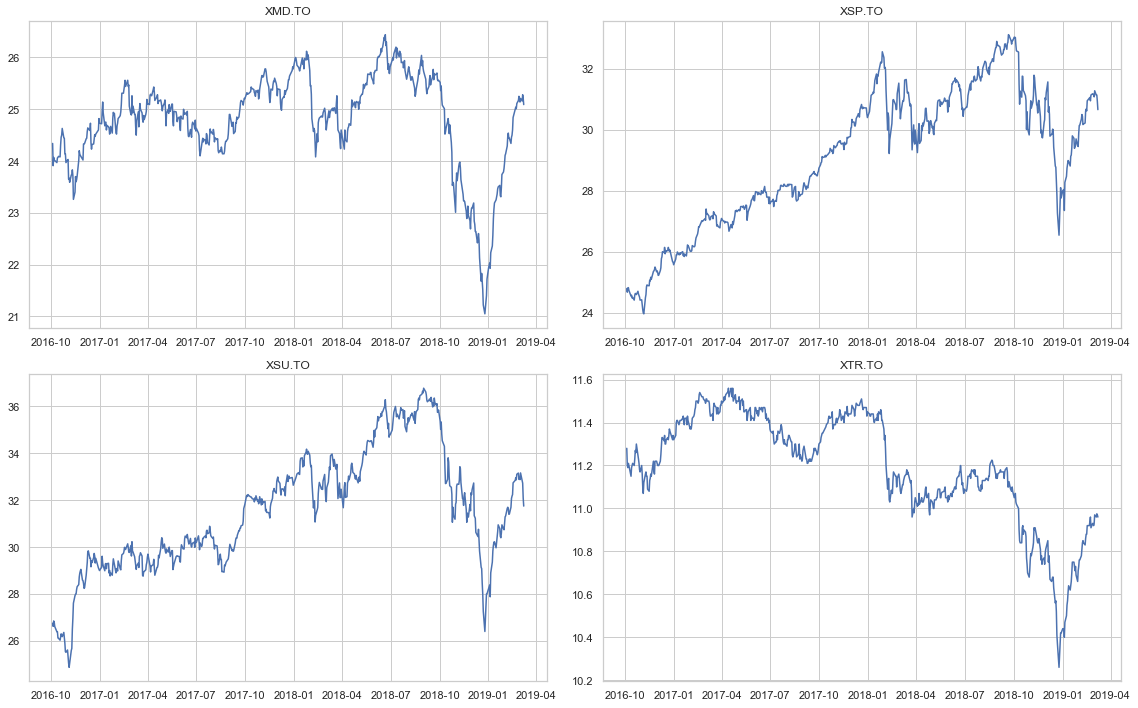

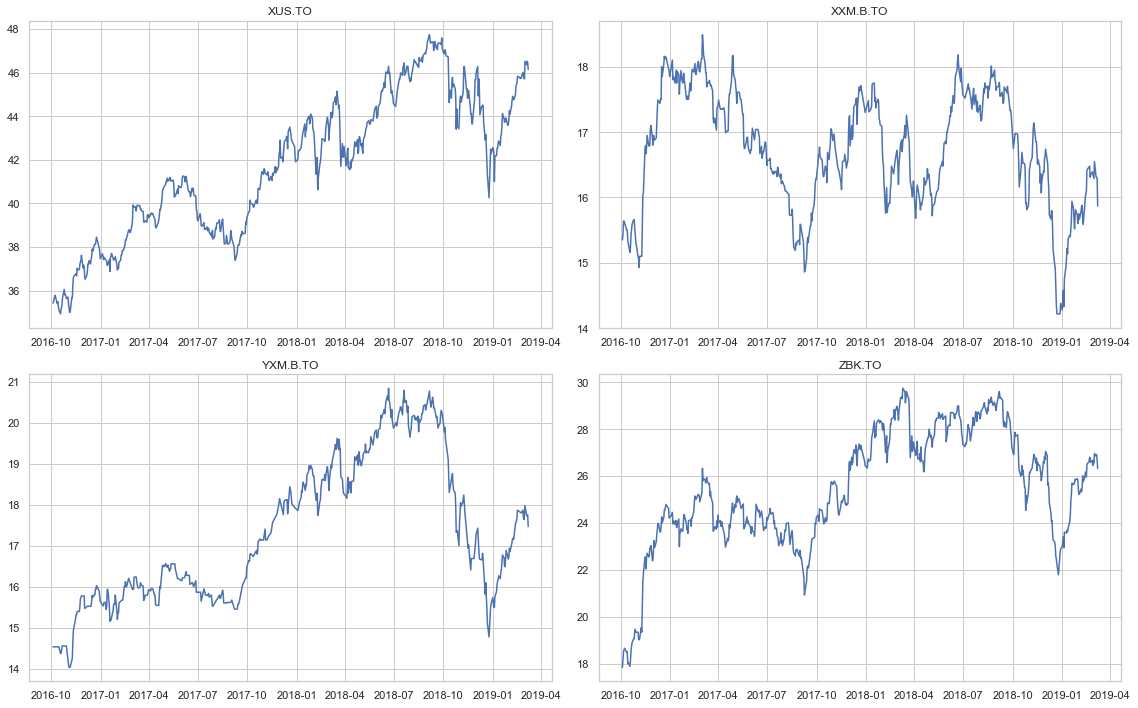

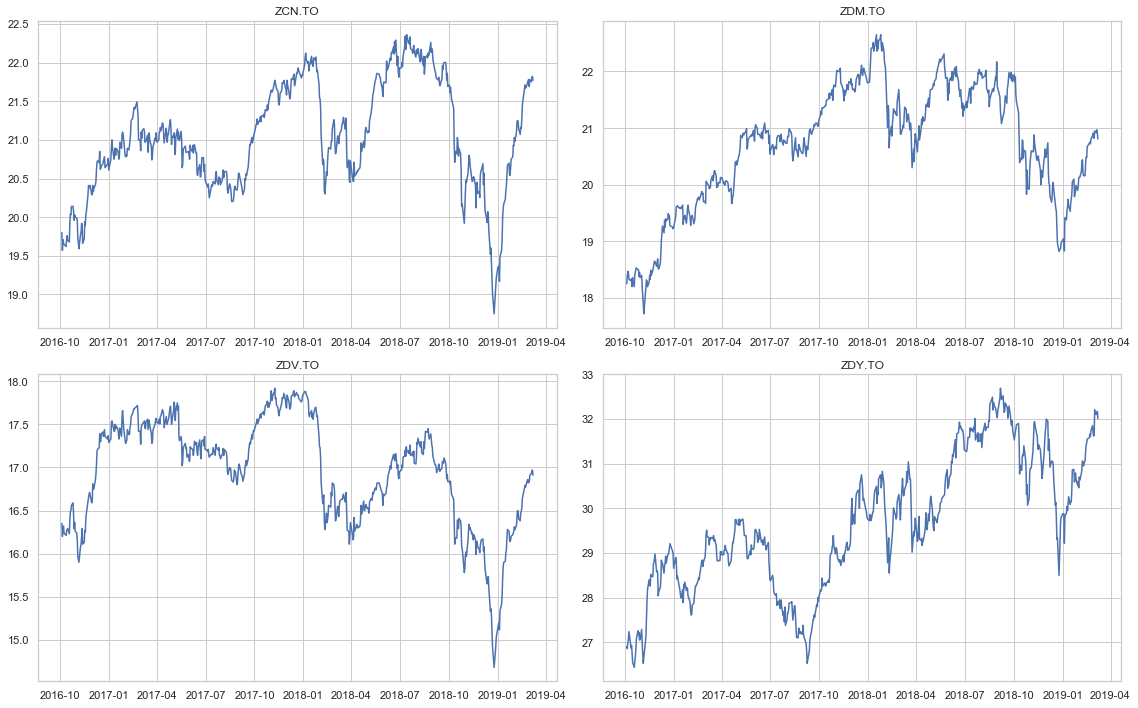

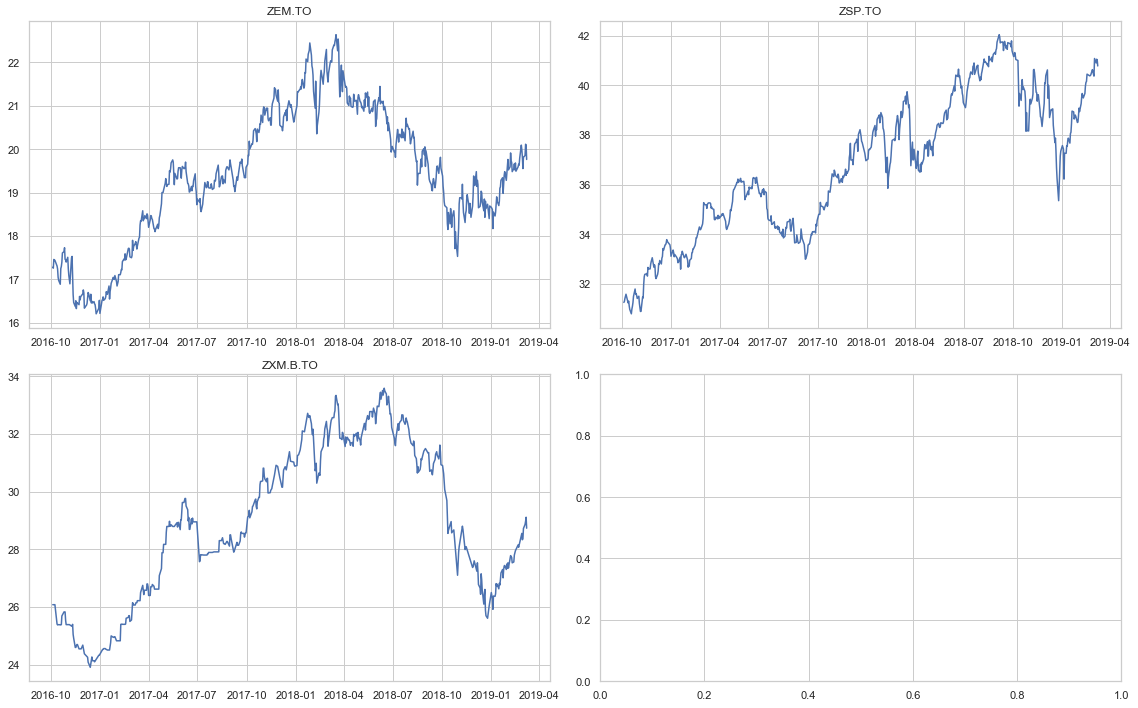

In [460]:
def chunks(l, n):
    print(l)
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

grouped = historicals.reset_index().set_index("end").groupby('symbol')

symbol_chunks = chunks(list(grouped.groups.keys()), 4)

for chunk in symbol_chunks:
    rows = math.ceil(len(chunk) / 2)
    fig, axs = plt.subplots(figsize=(16,10), nrows=rows, ncols=2)

    targets = zip(chunk, axs.flatten())
    for i, (key, ax) in enumerate(targets):
        ax.plot(grouped.get_group(key)['close'])
        ax.set_title(key)

    plt.tight_layout()
    plt.show()

In [453]:
historicals['daily_returns'] = historicals.groupby(level='symbol')['close'].apply(lambda x: x.pct_change())
historicals['total_returns'] = historicals.groupby(level='symbol')['daily_returns'].apply(lambda x:                                                                                        (1 + x).cumprod() - 1)

symbol
BOTZ          AxesSubplot(0.125,0.2;0.775x0.68)
CDZ.TO        AxesSubplot(0.125,0.2;0.775x0.68)
CHB.TO        AxesSubplot(0.125,0.2;0.775x0.68)
CIE.TO        AxesSubplot(0.125,0.2;0.775x0.68)
CJP.TO        AxesSubplot(0.125,0.2;0.775x0.68)
CLU.C.TO      AxesSubplot(0.125,0.2;0.775x0.68)
CRQ.TO        AxesSubplot(0.125,0.2;0.775x0.68)
CUD.TO        AxesSubplot(0.125,0.2;0.775x0.68)
CWO.TO        AxesSubplot(0.125,0.2;0.775x0.68)
CYH.TO        AxesSubplot(0.125,0.2;0.775x0.68)
EHE.B.TO      AxesSubplot(0.125,0.2;0.775x0.68)
ETHI.TO       AxesSubplot(0.125,0.2;0.775x0.68)
FTN.PRA.TO    AxesSubplot(0.125,0.2;0.775x0.68)
FXM.TO        AxesSubplot(0.125,0.2;0.775x0.68)
HCN.TO        AxesSubplot(0.125,0.2;0.775x0.68)
HEX.TO        AxesSubplot(0.125,0.2;0.775x0.68)
HIU.TO        AxesSubplot(0.125,0.2;0.775x0.68)
HIX.TO        AxesSubplot(0.125,0.2;0.775x0.68)
HSH.TO        AxesSubplot(0.125,0.2;0.775x0.68)
HXQ.TO        AxesSubplot(0.125,0.2;0.775x0.68)
HXS.TO        AxesSubplot(0.125,0

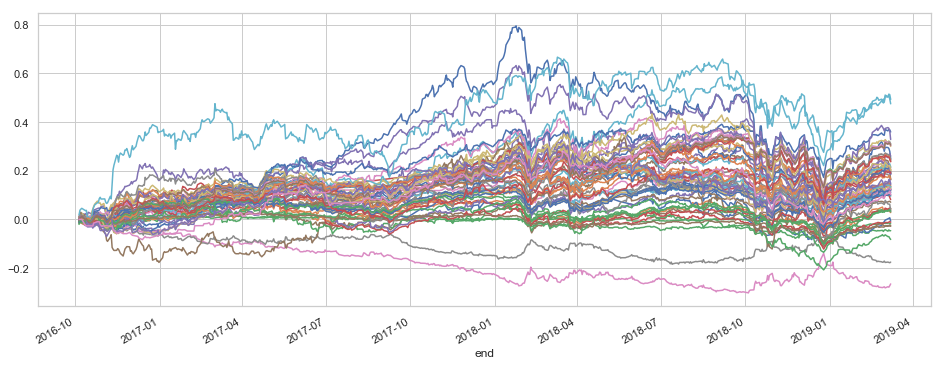

In [455]:
plt.figure(figsize=(16, 6))
historicals.reset_index().set_index("end").groupby('symbol')['total_returns'].plot()

In [431]:
historicals.groupby(level="symbol")["total_returns"].nth(-1)

symbol
BOTZ      0.248632
CDZ.TO    0.039761
CRQ.TO    0.111190
FXM.TO    0.081226
HEX.TO   -0.025411
HIX.TO   -0.175414
HXT.TO    0.203054
PDC.TO    0.044822
ROBO      0.327914
TAN       0.163438
Name: total_returns, dtype: float64

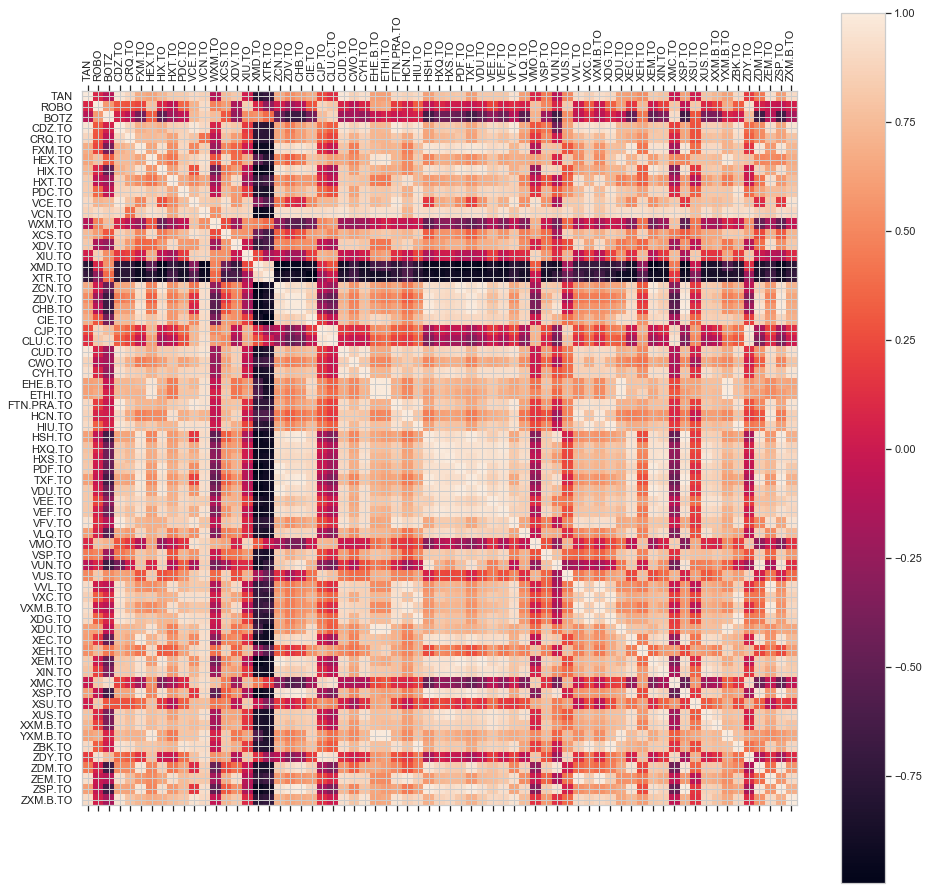

In [456]:
price_corr = historicals.reset_index().pivot('end','symbol')['close'].corr()

alpha = list(symbols.values())

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111)
cax = ax.matshow(price_corr, interpolation='nearest')
fig.colorbar(cax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

In [433]:
price_corr

symbol,BOTZ,CDZ.TO,CRQ.TO,FXM.TO,HEX.TO,HIX.TO,HXT.TO,PDC.TO,ROBO,TAN
symbol,,,,,,,,,,
BOTZ,1.000000,0.085557,0.641481,0.749189,0.040855,-0.709882,0.673323,0.240439,0.979582,0.869125
CDZ.TO,0.085557,1.000000,0.776064,0.598578,0.842038,-0.274633,0.292302,0.882110,0.070160,-0.076882
CRQ.TO,0.641481,0.776064,1.000000,0.895253,0.680266,-0.772895,0.790507,0.723745,0.666823,0.524651
FXM.TO,0.749189,0.598578,0.895253,1.000000,0.562868,-0.616932,0.598716,0.655127,0.712109,0.626697
HEX.TO,0.040855,0.842038,0.680266,0.562868,1.000000,-0.152411,0.199420,0.706676,-0.013024,-0.057432
HIX.TO,-0.709882,-0.274633,-0.772895,-0.616932,-0.152411,1.000000,-0.994748,-0.188004,-0.809056,-0.624300
HXT.TO,0.673323,0.292302,0.790507,0.598716,0.199420,-0.994748,1.000000,0.179970,0.775668,0.605517
PDC.TO,0.240439,0.882110,0.723745,0.655127,0.706676,-0.188004,0.179970,1.000000,0.176709,0.115991
ROBO,0.979582,0.070160,0.666823,0.712109,-0.013024,-0.809056,0.775668,0.176709,1.000000,0.855089
